### Imports

In [125]:
import hashlib
import os
import re
import time
from collections import Counter
from datetime import datetime

import contractions
import matplotlib.pyplot as plt
import nlpaug.augmenter.word as nlpaw
import nltk
import numpy as np
import onnx
import onnxruntime as ort
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

# from datasets import Dataset, DatasetDict, load_dataset
from dotenv import load_dotenv
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.ops import sigmoid_focal_loss
from tqdm import tqdm
from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer

from adopt import ADOPT

load_dotenv()


True

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Load the dataset

#### You can find this dataset on Kaggle uploaded by me. It is a collated dataset from a few different sources. https://www.kaggle.com/datasets/hawkeye2704/cyberbullying-dataset

In [4]:
df = pd.read_csv(r"./data/Collated_Dataset.csv")

In [5]:
df = df.dropna()

In [6]:
df.oh_label = df.oh_label.astype('int')

## Basic Data Exploration and Cleaning

In [6]:
def show_basic_stats(df):
    print(f"Total samples: {len(df)}")
    print("\nClass distribution:")
    print(df['oh_label'].value_counts(normalize=True) * 100)
    
    df['text_length'] = df['Text'].str.len()
    df['word_count'] = df['Text'].str.split().str.len()
    
    print("\nText length statistics:")
    print(df['text_length'].describe())
    print("\nWord count statistics:")
    print(df['word_count'].describe())

In [8]:
show_basic_stats(df)

Total samples: 251800

Class distribution:
oh_label
0    85.890389
1    14.109611
Name: proportion, dtype: float64

Text length statistics:
count    251800.000000
mean        371.938550
std         667.296813
min           1.000000
25%          82.000000
50%         166.000000
75%         387.000000
max       20030.000000
Name: text_length, dtype: float64

Word count statistics:
count    251800.000000
mean         63.512236
std         113.069698
min           0.000000
25%          14.000000
50%          29.000000
75%          67.000000
max        2832.000000
Name: word_count, dtype: float64


We can see there is a huge class imbalance in the dataset. Will be actioned upon later.

In [12]:
def plot_length_distributions(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.boxplot(x='oh_label', y='text_length', data=df, ax=ax1)
    ax1.set_title('Text Length Distribution by Class')
    ax1.set_ylim(0, df['text_length'].quantile(0.95))
    
    sns.boxplot(x='oh_label', y='word_count', data=df, ax=ax2)
    ax2.set_title('Word Count Distribution by Class')
    ax2.set_ylim(0, df['word_count'].quantile(0.95))
    
    plt.tight_layout()
    plt.show()

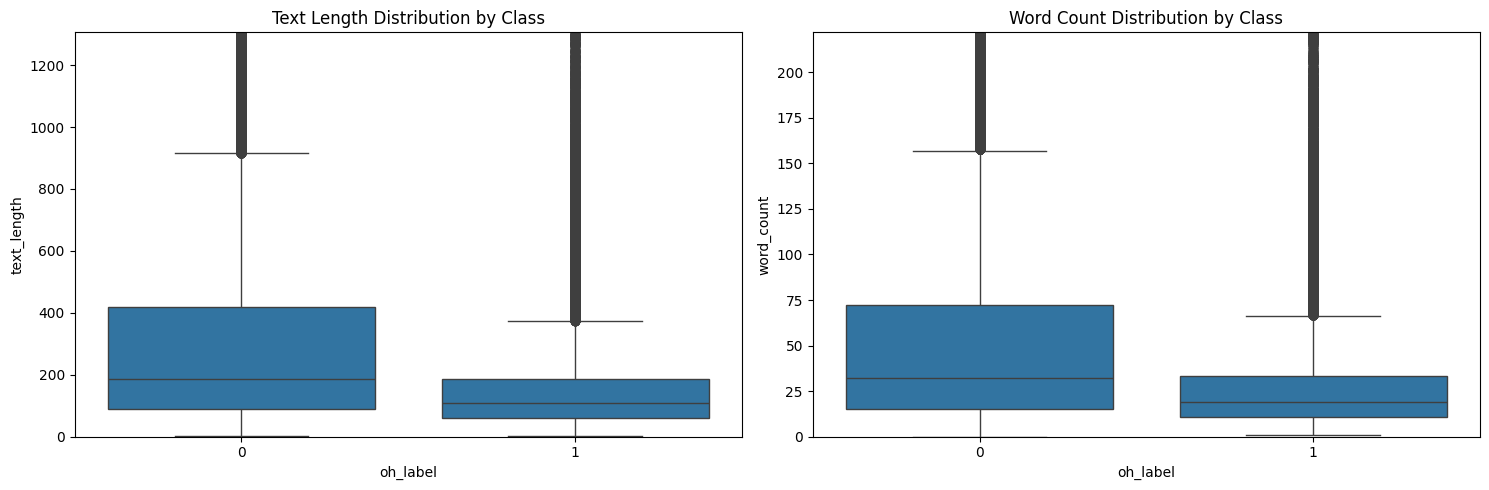

In [13]:
plot_length_distributions(df)

In [14]:
def analyze_common_words(df):

    toxic_words = ' '.join(df[df['oh_label'] == 1]['Text'].str.lower()).split()
    nontoxic_words = ' '.join(df[df['oh_label'] == 0]['Text'].str.lower()).split()

    toxic_freq = Counter(toxic_words).most_common(20)
    nontoxic_freq = Counter(nontoxic_words).most_common(20)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    words, counts = zip(*toxic_freq)
    ax1.barh(words, counts)
    ax1.set_title('Most Common Words in Toxic Comments')
    
    words, counts = zip(*nontoxic_freq)
    ax2.barh(words, counts)
    ax2.set_title('Most Common Words in Non-toxic Comments')
    
    plt.tight_layout()
    plt.show()

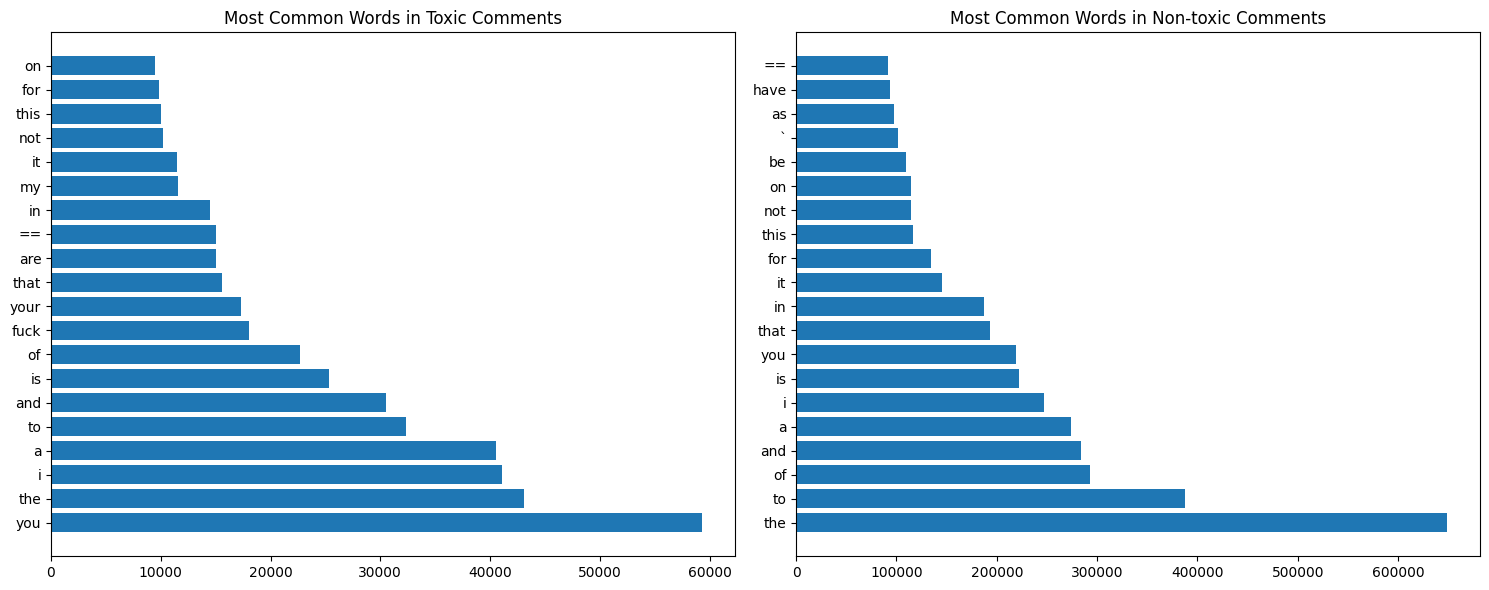

In [15]:
analyze_common_words(df)

With stopwords not removed, there is not much we can make out of this, we will maybe try it again once we do NLP specific cleaning later.

In [16]:
def check_data_quality(df):
    print("Data Quality Metrics:")
    print(f"Empty texts: {(df['Text'].str.strip() == '').sum()}")
    print(f"Very short texts (<5 chars): {(df['Text'].str.len() < 5).sum()}")
    print(f"Duplicate texts: {df['Text'].duplicated().sum()}")

In [17]:
check_data_quality(df)

Data Quality Metrics:
Empty texts: 4
Very short texts (<5 chars): 109
Duplicate texts: 11815


That is not very good and let's action it real quick

In [7]:
df_cleaned = df[df['Text'].str.strip().str.len() >= 5].copy()
df_cleaned = df_cleaned.drop_duplicates(subset=['Text']).reset_index(drop=True)

print("Original dataset size:", len(df))
print("After removing short/empty texts:", len(df[df['Text'].str.strip().str.len() >= 5]))
print("Final size after removing duplicates:", len(df_cleaned))
print("\nClass distribution after cleaning:")
print(df_cleaned['oh_label'].value_counts(normalize=True).round(3))

Original dataset size: 251800
After removing short/empty texts: 251499
Final size after removing duplicates: 239824

Class distribution after cleaning:
oh_label
0    0.885
1    0.115
Name: proportion, dtype: float64


In [8]:
df = df_cleaned.copy()

In [20]:
def analyze_ngrams(df, class_label, n=1, top_k=15):
    # Get texts for specific class (toxic or non-toxic)
    texts = df[df['oh_label'] == class_label]['Text'].values
    
    # Create and fit CountVectorizer
    vectorizer = CountVectorizer(ngram_range=(n,n), 
                               stop_words='english',
                               max_features=top_k)
    ngram_counts = vectorizer.fit_transform(texts)
    
    # Get frequencies
    sum_words = ngram_counts.sum(axis=0).A1
    words_freq = list(zip(vectorizer.get_feature_names_out(), sum_words))
    return sorted(words_freq, key=lambda x: x[1], reverse=True)

def plot_ngrams_comparison(df):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    
    for i, n in enumerate([1, 2, 3]):
        # Toxic ngrams
        toxic_ngrams = analyze_ngrams(df, 1, n)
        words, counts = zip(*toxic_ngrams)
        axes[0, i].barh(words, counts)
        axes[0, i].set_title(f'Top {n}-grams in Toxic Comments')
        
        # Non-toxic ngrams
        nontoxic_ngrams = analyze_ngrams(df, 0, n)
        words, counts = zip(*nontoxic_ngrams)
        axes[1, i].barh(words, counts)
        axes[1, i].set_title(f'Top {n}-grams in Non-toxic Comments')
    
    plt.tight_layout()
    plt.show()

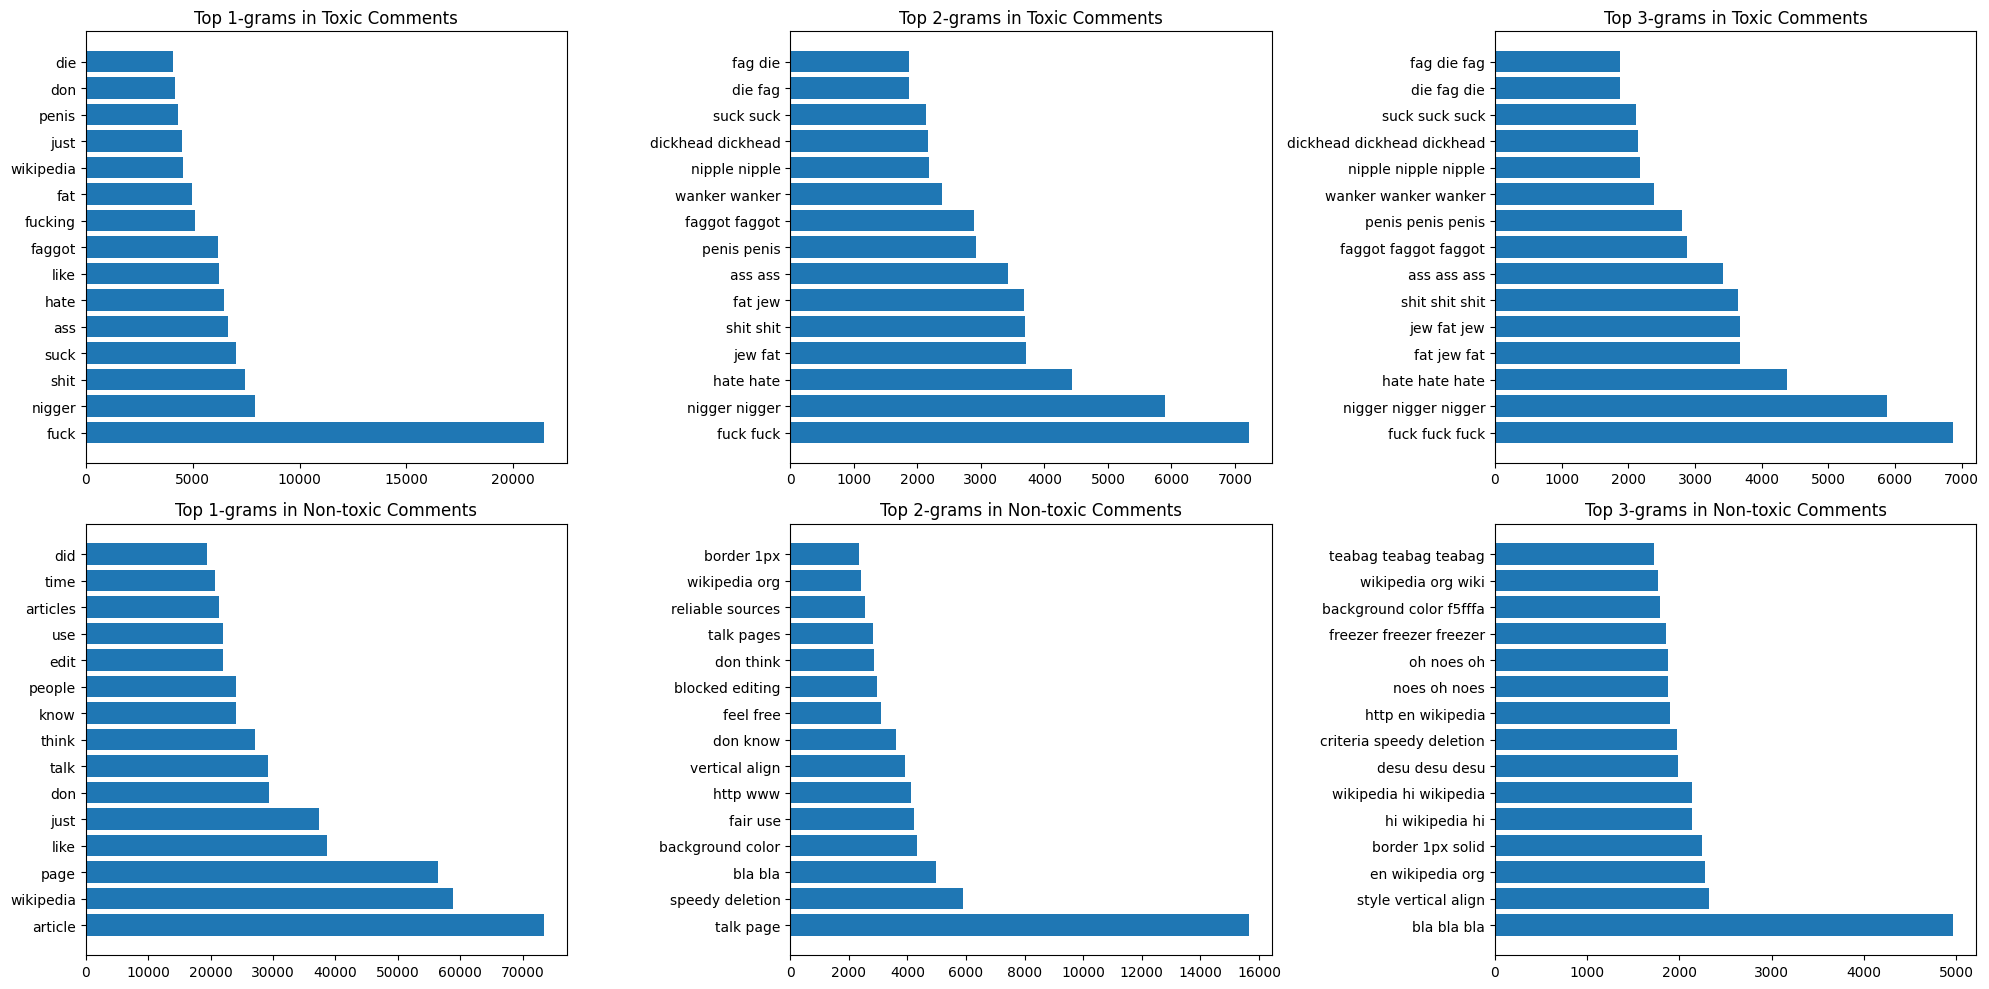

In [21]:
plot_ngrams_comparison(df)

Some level of hate there ! 😐

In [24]:
def analyze_special_chars(df):
    # Calculate percentages of texts containing each pattern
    patterns = {
        'Emojis': r'[\U0001F300-\U0001F9FF]',
        'Special Characters (!@#$%)': r'[!@#$%^&*(),.?":{}|<>]',
        'UPPERCASE Words': r'\b[A-Z]{2,}\b'
    }
    
    results = pd.DataFrame(columns=['Pattern', 'Toxic_Percentage', 'NonToxic_Percentage', 'Interpretation'])
    
    for pattern_name, pattern in patterns.items():
        # Percentage of texts containing the pattern
        toxic_pct = (df[df['oh_label'] == 1]['Text'].str.contains(pattern, regex=True).mean() * 100)
        nontoxic_pct = (df[df['oh_label'] == 0]['Text'].str.contains(pattern, regex=True).mean() * 100)
        
        # Create interpretation
        difference = toxic_pct - nontoxic_pct
        if abs(difference) < 1:
            interpretation = "Similar usage in both classes"
        else:
            interpretation = f"{'More' if difference > 0 else 'Less'} common in toxic texts by {abs(difference):.1f}%"
        
        results.loc[len(results)] = [pattern_name, toxic_pct, nontoxic_pct, interpretation]
    
    # Print formatted results
    print("Special Character Usage Analysis")
    print("-" * 80)
    for _, row in results.iterrows():
        print(f"\n{row['Pattern']}:")
        print(f"• Found in {row['Toxic_Percentage']:.1f}% of toxic texts")
        print(f"• Found in {row['NonToxic_Percentage']:.1f}% of non-toxic texts")
        print(f"• {row['Interpretation']}")
    
    # Visualization
    plt.figure(figsize=(10, 6))
    x = range(len(patterns))
    width = 0.35
    
    plt.bar([i - width/2 for i in x], results['Toxic_Percentage'], 
            width, label='Toxic', color='salmon')
    plt.bar([i + width/2 for i in x], results['NonToxic_Percentage'], 
            width, label='Non-toxic', color='lightblue')
    
    plt.title('Pattern Usage in Toxic vs Non-toxic Texts')
    plt.xlabel('Pattern Type')
    plt.ylabel('Percentage of Texts (%)')
    plt.xticks(x, patterns.keys(), rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return results

Special Character Usage Analysis
--------------------------------------------------------------------------------

Emojis:
• Found in 0.2% of toxic texts
• Found in 0.1% of non-toxic texts
• Similar usage in both classes

Special Characters (!@#$%):
• Found in 92.1% of toxic texts
• Found in 97.0% of non-toxic texts
• Less common in toxic texts by 4.9%

UPPERCASE Words:
• Found in 36.6% of toxic texts
• Found in 33.2% of non-toxic texts
• More common in toxic texts by 3.4%


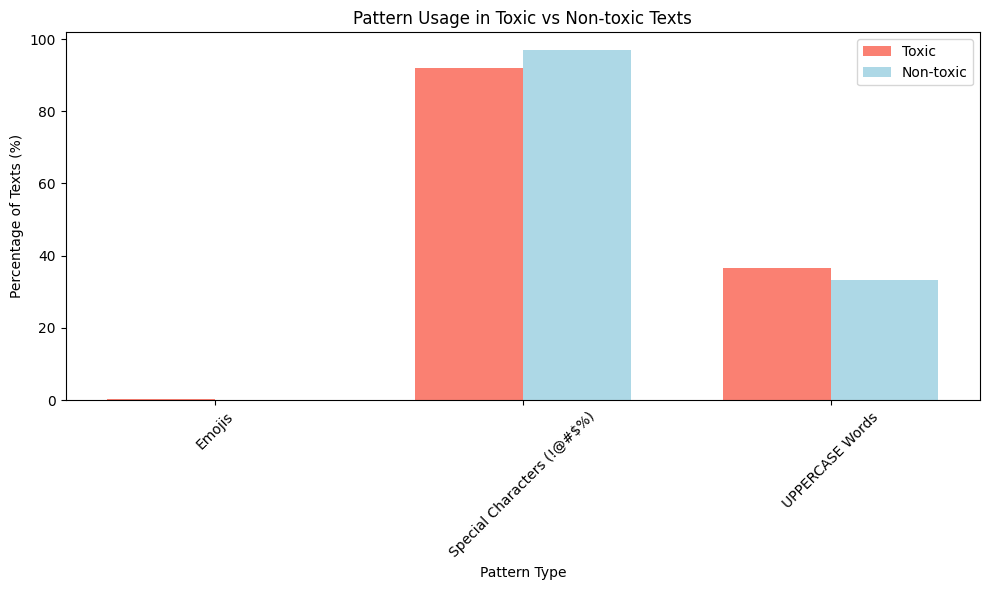

In [23]:
results = analyze_special_chars(df)

* Since this is done with a collated dataset from various sources, only one of them might have emojis (that too sparsely) and that reflects here. 
* Special characters are present in a lot of tweets, might denote something like yelling or cussing. 
* Uppercase words are also considerably present indicating shouting in the internet slang.

In [9]:
def preprocess_text(df, text_col='Text'):
    df = df.copy()
    
    def clean_text(text):
        # Expand contractions (e.g., "don't" -> "do not")
        text = contractions.fix(str(text))
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'[\U0001F300-\U0001F9FF]', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = ' '.join(text.split())
        return text
    
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    custom_stops = {'rt', 'via', 'amp', 'like', 'just'}
    stop_words.update(custom_stops)
    
    print("Starting preprocessing pipeline...")
    
    df['cleaned_text'] = df[text_col].apply(clean_text)
    print("Basic cleaning completed")
    
    df['tokens'] = df['cleaned_text'].apply(word_tokenize)
    print("Tokenization completed")
    
    df['processed_text'] = df['tokens'].apply(
        lambda tokens: ' '.join([
            lemmatizer.lemmatize(word) 
            for word in tokens 
            if word not in stop_words and len(word) > 2
        ])
    )
    print("Stopword removal and lemmatization completed")
    
    df = df[df['processed_text'].str.strip() != '']
    
    return df

In [10]:
processed_df = preprocess_text(df)

Starting preprocessing pipeline...
Basic cleaning completed
Tokenization completed
Stopword removal and lemmatization completed


In [11]:
comparison = pd.DataFrame({
        'Original': processed_df['Text'].head(),
        'Processed': processed_df['processed_text'].head()
    })
display(comparison)

,Original,Processed
0,Get fucking real dude.,get fucking real dude
1,She is as dirty as they come and that crook ...,dirty come crook rengel dems fucking corrupt j...
2,why did you fuck it up. I could do it all day...,fuck could day let hour ping later sched writi...
3,Dude they dont finish enclosing the fucking s...,dude finish enclosing fucking shower hate half...
4,WTF are you talking about Men? No men thats n...,wtf talking men men menage gay


* There is an imbalance issue we're still yet to fix. Since this is text data, SMOTE cannot be directly applied here since it operates in the feature space and it would just explode given we have so much data and that too being text. The plan is to counter the imbalance by using custom weighted loss functions and imbalance-neutral evaluation metrics during the NN training. If that doesn't work, we will implement something close to SMOTE but not it.

## Saving the preprocessed dataset to HuggingFace

In [18]:
hf_dataset = Dataset.from_pandas(processed_df)
hf_dataset.push_to_hub(
    "Cyberbullying-Toxicity-Tweets",
    token=os.getenv("HUGGINGFACE_TOKEN")
)

print("Dataset saved to Hugging Face Hub")

Uploading the dataset shards: 100%|██████████| 1/1 [00:24<00:00, 24.42s/it]


Dataset saved to Hugging Face Hub


In [20]:
dataset = load_dataset("karthikarunr/Cyberbullying-Toxicity-Tweets")
processed_df = dataset['train'].to_pandas()
display(processed_df)

,Text,oh_label,cleaned_text,tokens,processed_text,__index_level_0__
0,Get fucking real dude.,1,get fucking real dude,"[get, fucking, real, dude]",get fucking real dude,0
1,She is as dirty as they come and that crook ...,1,she is as dirty as they come and that crook re...,"[she, is, as, dirty, as, they, come, and, that...",dirty come crook rengel dems fucking corrupt j...,1
2,why did you fuck it up. I could do it all day...,1,why did you fuck it up i could do it all day t...,"[why, did, you, fuck, it, up, i, could, do, it...",fuck could day let hour ping later sched writi...,2
3,Dude they dont finish enclosing the fucking s...,1,dude they do not finish enclosing the fucking ...,"[dude, they, do, not, finish, enclosing, the, ...",dude finish enclosing fucking shower hate half...,3
4,WTF are you talking about Men? No men thats n...,1,wtf are you talking about men no men that is n...,"[wtf, are, you, talking, about, men, no, men, ...",wtf talking men men menage gay,4
...,...,...,...,...,...,...
239460,@Vandaliser @sajid_fairooz @IsraeliRegime I'd ...,1,vandaliser sajidfairooz israeliregime i would ...,"[vandaliser, sajidfairooz, israeliregime, i, w...",vandaliser sajidfairooz israeliregime would ra...,239819
239461,@hassanrahman11 @ToAllahWeReturn One Christ te...,1,hassanrahman toallahwereturn one christ terror...,"[hassanrahman, toallahwereturn, one, christ, t...",hassanrahman toallahwereturn one christ terror...,239820
239462,@dankmtl @AAlwuhaib1977 @PeaceNotHate_ No assh...,1,dankmtl aalwuhaib peacenothate no asshole the ...,"[dankmtl, aalwuhaib, peacenothate, no, asshole...",dankmtl aalwuhaib peacenothate asshole israeli...,239821
239463,Since 1/3 of all #Islam believes that people w...,1,since of all islam believes that people who le...,"[since, of, all, islam, believes, that, people...",since islam belief people leave religion murde...,239822


## Dataset Splitting

In [12]:
processed_df.columns

Index(['Text', 'oh_label', 'cleaned_text', 'tokens', 'processed_text'], dtype='object')

In [13]:
df_final = processed_df[['processed_text', 'oh_label']].copy()

In [14]:
# Stratified Splitting

train_val_df, test_df = train_test_split(
    df_final,
    test_size=0.15,
    random_state=42,
    stratify=df_final['oh_label']
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.176,  # 0.176 * 0.85 = 0.15
    random_state=42,
    stratify=train_val_df['oh_label']
)

In [15]:
print("Dataset splits:")
print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

print("\nClass distribution in splits:")
print("\nTrain set:")
print(train_df['oh_label'].value_counts(normalize=True))
print("\nValidation set:")
print(val_df['oh_label'].value_counts(normalize=True))
print("\nTest set:")
print(test_df['oh_label'].value_counts(normalize=True))

Dataset splits:
Train set: 167721 samples
Validation set: 35824 samples
Test set: 35920 samples

Class distribution in splits:

Train set:
oh_label
0    0.884982
1    0.115018
Name: proportion, dtype: float64

Validation set:
oh_label
0    0.884993
1    0.115007
Name: proportion, dtype: float64

Test set:
oh_label
0    0.884994
1    0.115006
Name: proportion, dtype: float64


* A good split with equal distributions of the target class in all different sets has been achieved. We will see how it goes during the training and come back to this if it goes south.

In [16]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("\nSample from train set:")
print(train_df.head(2))



Sample from train set:
                                      processed_text  oh_label
0                                  take mom get rich         0
1  disagree general point cptnono always think fu...         0


## Model Loading

* The other notebook in this repo (which was a 2020 work) focused on solving this problem with very lightweight but not so robust solutions like TF-IDF and count-based embeddings with neural network architectures like a simple multi-layer perceptron, LSTMs and TextCNNs. With the boom of _transformers_ in the recent days, it would not be wise to not tap into that potential. Hence we will be focusing on building a lightweight pipeline with the use of low-param transformer models.

In [17]:
model_name = "/home/karthik_arun/ml/models/distilbert/model"  
tokenizer_name = "/home/karthik_arun/ml/models/distilbert/tokenizer"  
# or "albert-base-v2" 
# or "microsoft/deberta-v3-small" 

tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    problem_type="single_label_classification"
)

In [163]:
tokenizer.save_pretrained('./models/distilbert/tokenizer')

('./models/distilbert/tokenizer/tokenizer_config.json',
 './models/distilbert/tokenizer/special_tokens_map.json',
 './models/distilbert/tokenizer/vocab.txt',
 './models/distilbert/tokenizer/added_tokens.json',
 './models/distilbert/tokenizer/tokenizer.json')

In [164]:
model.save_pretrained('models/distilbert/model')

## Finding optimal max_length for the tokenizer

In [165]:
def analyze_text_lengths(df, tokenizer, percentile=95):
    lengths = []
    for text in df['processed_text']:
        tokens = tokenizer.encode(text, add_special_tokens=True)
        lengths.append(len(tokens))
    lengths = np.array(lengths)
    stats = {
        'mean': np.mean(lengths),
        'median': np.median(lengths),
        'percentile_95': np.percentile(lengths, percentile),
        'max': np.max(lengths),
        'min': np.min(lengths)
    }
    
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=50, edgecolor='black')
    plt.axvline(stats['mean'], color='r', linestyle='dashed', linewidth=2, label=f"Mean: {stats['mean']:.1f}")
    plt.axvline(stats['percentile_95'], color='g', linestyle='dashed', linewidth=2, 
                label=f"{percentile}th percentile: {stats['percentile_95']:.1f}")
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Text Lengths after Tokenization')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("\nSequence Length Statistics:")
    for key, value in stats.items():
        print(f"{key}: {value:.1f}")
    
    potential_lengths = [32, 64, 128, 256, 512]
    print("\nData coverage at different max_lengths:")
    for length in potential_lengths:
        coverage = (lengths <= length).mean() * 100
        print(f"max_length={length}: {coverage:.1f}% of texts covered")
    
    return stats

Token indices sequence length is longer than the specified maximum sequence length for this model (1213 > 512). Running this sequence through the model will result in indexing errors


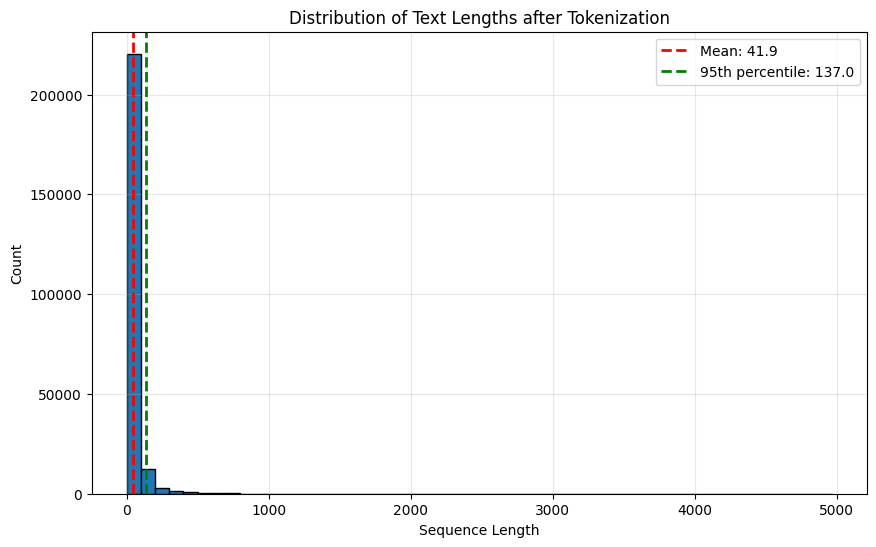


Sequence Length Statistics:
mean: 41.9
median: 20.0
percentile_95: 137.0
max: 4964.0
min: 3.0

Data coverage at different max_lengths:
max_length=32: 67.5% of texts covered
max_length=64: 85.1% of texts covered
max_length=128: 94.4% of texts covered
max_length=256: 98.0% of texts covered
max_length=512: 99.6% of texts covered

Analyzing lengths by class:

Toxic texts:


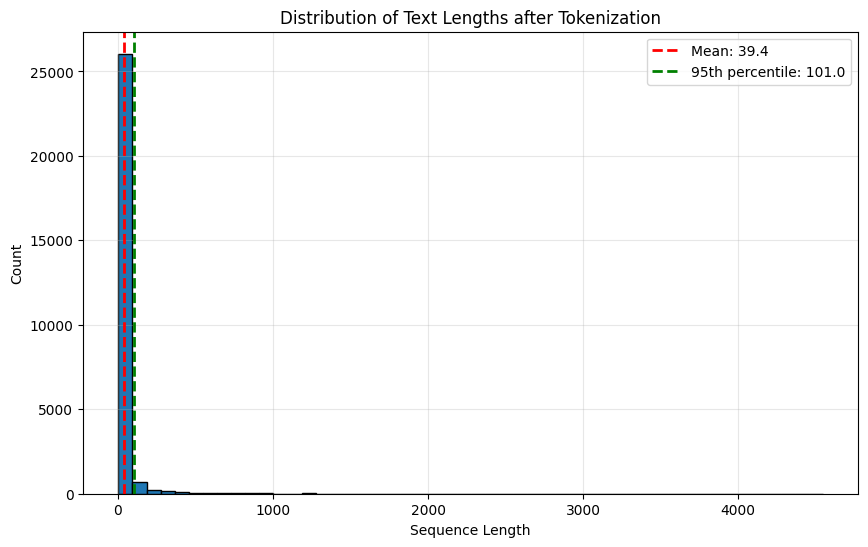


Sequence Length Statistics:
mean: 39.4
median: 16.0
percentile_95: 101.0
max: 4547.0
min: 3.0

Data coverage at different max_lengths:
max_length=32: 81.5% of texts covered
max_length=64: 91.7% of texts covered
max_length=128: 96.0% of texts covered
max_length=256: 97.9% of texts covered
max_length=512: 98.9% of texts covered

Non-toxic texts:


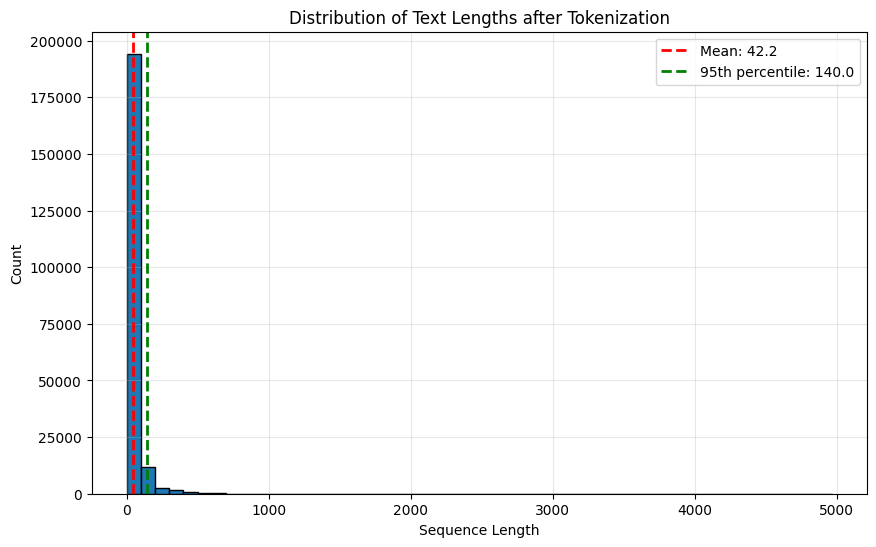


Sequence Length Statistics:
mean: 42.2
median: 21.0
percentile_95: 140.0
max: 4964.0
min: 3.0

Data coverage at different max_lengths:
max_length=32: 65.7% of texts covered
max_length=64: 84.2% of texts covered
max_length=128: 94.2% of texts covered
max_length=256: 98.0% of texts covered
max_length=512: 99.7% of texts covered


In [40]:
stats = analyze_text_lengths(processed_df, tokenizer)

print("\nAnalyzing lengths by class:")
print("\nToxic texts:")
toxic_stats = analyze_text_lengths(processed_df[processed_df['oh_label'] == 1], tokenizer)
print("\nNon-toxic texts:")
nontoxic_stats = analyze_text_lengths(processed_df[processed_df['oh_label'] == 0], tokenizer)


* 128 looks to be alright given it covers 95% of the texts. And 512 is the max for this model's tokenizer anyway.

## Dataset Prep

In [18]:
class CyberbullyingDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.texts = df['processed_text'].values
        self.labels = df['oh_label'].values
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [19]:
train_dataset = CyberbullyingDataset(train_df, tokenizer)
val_dataset = CyberbullyingDataset(val_df, tokenizer)
test_dataset = CyberbullyingDataset(test_df, tokenizer)

In [20]:
print("Dataset sizes:")
print(f"Train: {len(train_dataset)}")
print(f"Validation: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")

Dataset sizes:
Train: 167721
Validation: 35824
Test: 35920


In [21]:
sample = train_dataset[0]
print("\nSample input:")
print(f"Input shape: {sample['input_ids'].shape}")
print(f"Attention mask shape: {sample['attention_mask'].shape}")
print(f"Label: {sample['labels']}")


Sample input:
Input shape: torch.Size([128])
Attention mask shape: torch.Size([128])
Label: 0


In [22]:
sample_text = tokenizer.decode(sample['input_ids'])
print("\nDecoded sample text:")
print(sample_text)


Decoded sample text:
[CLS] take mom get rich [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [24]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

In [26]:
val_loader = DataLoader(
    val_dataset,
    batch_size=64, 
    shuffle=False,
    num_workers=0
)

In [27]:
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

In [28]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['oh_label']),
    y=train_df['oh_label']
)
class_weights = torch.FloatTensor(class_weights).to(device)

In [29]:
class_weights

tensor([0.5650, 4.3471], device='cuda:0')

In [30]:
try:
    start_time = time.time()
    sample_batch = next(iter(train_loader))
    end_time = time.time()

    print(f"Time taken to load batch: {end_time - start_time:.2f} seconds")
    print("\nBatch structure:")
    for k, v in sample_batch.items():
        print(f"{k}: shape {v.shape}")
except Exception as e:
    print(f"Error loading batch: {str(e)}")

Time taken to load batch: 0.02 seconds

Batch structure:
input_ids: shape torch.Size([32, 128])
attention_mask: shape torch.Size([32, 128])
labels: shape torch.Size([32])


## Training with the full data - no tweaks

In [31]:
training_args = {
    'num_epochs': 5,
    'learning_rate': 5e-5,
    'warmup_steps': 0.1,
    'weight_decay': 0.01,
    'gradient_clipping': 1.0,
    'batch_size': 64
}

total_steps = len(train_loader) * training_args['num_epochs']
warmup_steps = int(total_steps * training_args['warmup_steps'])

print("\nTraining setup:")
print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches per epoch: {len(val_loader)}")
print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {warmup_steps}")


Training setup:
Training batches per epoch: 5242
Validation batches per epoch: 560
Total training steps: 26210
Warmup steps: 2621


In [32]:
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=0.75, gamma=2):
#         super().__init__()
#         self.alpha = alpha
#         self.gamma = gamma
    
#     def forward(self, inputs, targets):
#         ce_loss = F.cross_entropy(inputs, targets, reduction='none')
#         pt = torch.exp(-ce_loss)
#         focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
#         return focal_loss.mean()

# # Replace previous criterion
# criterion = FocalLoss()

In [33]:
class CyberbullyingClassifier(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", dropout=0.5):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.layer_norm = nn.LayerNorm(self.bert.config.hidden_size)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1)
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        return self.classifier(pooled_output)

In [34]:
model = CyberbullyingClassifier()
model = model.to(device)

In [35]:
for m in model.modules():
  for name, params in m.named_parameters():
    print(name, params.requires_grad)

bert.embeddings.word_embeddings.weight True
bert.embeddings.position_embeddings.weight True
bert.embeddings.LayerNorm.weight True
bert.embeddings.LayerNorm.bias True
bert.transformer.layer.0.attention.q_lin.weight True
bert.transformer.layer.0.attention.q_lin.bias True
bert.transformer.layer.0.attention.k_lin.weight True
bert.transformer.layer.0.attention.k_lin.bias True
bert.transformer.layer.0.attention.v_lin.weight True
bert.transformer.layer.0.attention.v_lin.bias True
bert.transformer.layer.0.attention.out_lin.weight True
bert.transformer.layer.0.attention.out_lin.bias True
bert.transformer.layer.0.sa_layer_norm.weight True
bert.transformer.layer.0.sa_layer_norm.bias True
bert.transformer.layer.0.ffn.lin1.weight True
bert.transformer.layer.0.ffn.lin1.bias True
bert.transformer.layer.0.ffn.lin2.weight True
bert.transformer.layer.0.ffn.lin2.bias True
bert.transformer.layer.0.output_layer_norm.weight True
bert.transformer.layer.0.output_layer_norm.bias True
bert.transformer.layer.1.a

In [36]:
tofreeze = ["bert.transformer.layer."]

In [37]:
for m in model.modules():
  for name, params in m.named_parameters():
    if any(prefix for prefix in tofreeze if name.startswith(prefix)):
        params.requires_grad = False
        print(name, params.requires_grad)

bert.transformer.layer.0.attention.q_lin.weight False
bert.transformer.layer.0.attention.q_lin.bias False
bert.transformer.layer.0.attention.k_lin.weight False
bert.transformer.layer.0.attention.k_lin.bias False
bert.transformer.layer.0.attention.v_lin.weight False
bert.transformer.layer.0.attention.v_lin.bias False
bert.transformer.layer.0.attention.out_lin.weight False
bert.transformer.layer.0.attention.out_lin.bias False
bert.transformer.layer.0.sa_layer_norm.weight False
bert.transformer.layer.0.sa_layer_norm.bias False
bert.transformer.layer.0.ffn.lin1.weight False
bert.transformer.layer.0.ffn.lin1.bias False
bert.transformer.layer.0.ffn.lin2.weight False
bert.transformer.layer.0.ffn.lin2.bias False
bert.transformer.layer.0.output_layer_norm.weight False
bert.transformer.layer.0.output_layer_norm.bias False
bert.transformer.layer.1.attention.q_lin.weight False
bert.transformer.layer.1.attention.q_lin.bias False
bert.transformer.layer.1.attention.k_lin.weight False
bert.transformer

In [38]:
print(model)

CyberbullyingClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1)

In [39]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTotal parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')


Total parameters: 66,562,049
Trainable parameters: 24,034,817


In [40]:
optimizer = ADOPT(
    model.parameters(), 
    lr=5e-5,
)


In [41]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001, mode='max', verbose=True):
        """
        patience: Number of epochs to wait before stopping
        min_delta: Minimum change in monitored value to qualify as an improvement
        mode: 'min' for loss, 'max' for metrics like F1
        """
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.verbose = verbose
        self.counter = 0
        self.best_value = None
        self.early_stop = False
        self.min_delta *= 1 if mode == 'max' else -1
    
    def __call__(self, current_value):
        if self.best_value is None:
            self.best_value = current_value
            return False
        
        if self.mode == 'max':
            delta = current_value - self.best_value
        else:
            delta = self.best_value - current_value
            
        if delta > self.min_delta:
            self.best_value = current_value
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                return True
        return False

In [42]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=2,
    verbose=True
)

/home/karthik_arun/tf/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [44]:
print("Training components initialized:")
# print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Class weights: {class_weights}")

Training components initialized:
Optimizer: ADOPT (
Parameter Group 0
    betas: (0.9, 0.9999)
    capturable: False
    decoupled: False
    differentiable: False
    eps: 1e-06
    foreach: None
    fused: None
    lr: 5e-05
    maximize: False
    weight_decay: 0.0
)
Class weights: tensor([0.5650, 4.3471], device='cuda:0')


In [45]:
def generate_experiment_id(train_data_size, model_config):
    """Generate unique experiment ID based on data and model characteristics"""
    # Create a unique string combining important characteristics
    unique_str = f"{train_data_size}_{model_config}"
    return hashlib.md5(unique_str.encode()).hexdigest()[:8]

In [46]:
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []

    progress_bar = tqdm(train_loader, desc='Training')

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = sigmoid_focal_loss(outputs.squeeze(), labels.float(), alpha=0.75, gamma=2.5, reduction='mean')
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        predictions.extend((torch.sigmoid(outputs) > 0.5).squeeze().cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    epoch_loss = total_loss / len(train_loader)
    epoch_f1 = f1_score(true_labels, predictions, average='weighted')

    return epoch_loss, epoch_f1

In [47]:
def evaluate(model, val_loader, device):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = sigmoid_focal_loss(outputs.squeeze(), labels.float(), alpha=0.75, gamma=2.5, reduction='mean')

            total_loss += loss.item()

            predictions.extend((torch.sigmoid(outputs) > 0.5).squeeze().cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    val_loss = total_loss / len(val_loader)
    val_f1 = f1_score(true_labels, predictions, average='weighted')

    report = classification_report(true_labels, predictions)

    return val_loss, val_f1, report

In [48]:
def save_checkpoint(model, optimizer, epoch, train_loss, val_loss, val_f1, 
                   experiment_id, checkpoint_type="last", checkpoint_dir="checkpoints"):
    
    exp_dir = os.path.join(checkpoint_dir, experiment_id)
    os.makedirs(exp_dir, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_f1': val_f1,
        'timestamp': timestamp,
        'experiment_id': experiment_id
    }
    
    filename = f"{checkpoint_type}_checkpoint.pt"
    filepath = os.path.join(exp_dir, filename)
    torch.save(checkpoint, filepath)
    
    metadata_file = os.path.join(exp_dir, "experiment_info.txt")
    with open(metadata_file, 'a') as f:
        f.write(f"\nCheckpoint saved at {timestamp}: {checkpoint_type}")
        f.write(f"\nEpoch: {epoch}, Val F1: {val_f1:.4f}")

In [49]:
def load_checkpoint(model, optimizer, experiment_id, checkpoint_type="last", checkpoint_dir="checkpoints"):
    """Load checkpoint for specific experiment"""
    exp_dir = os.path.join(checkpoint_dir, experiment_id)
    filename = os.path.join(exp_dir, f"{checkpoint_type}_checkpoint.pt")
    
    if os.path.exists(filename):
        print(f"Loading checkpoint from experiment {experiment_id}")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_f1 = checkpoint.get('val_f1', 0)
        print(f"Resuming from epoch {start_epoch} with validation F1: {best_val_f1:.4f}")
        return start_epoch, best_val_f1
    return 0, 0

In [50]:
def train_model(model, train_loader, val_loader, optimizer, scheduler,
                device, experiment_id=None, checkpoint_dir="checkpoints", num_epochs=5):
    """Training with experiment tracking"""
    
    # Generate experiment ID if not provided
    if experiment_id is None:
        experiment_id = generate_experiment_id(
            train_data_size=len(train_loader.dataset),
            model_config=model.__class__.__name__
        )
    
    print(f"Starting experiment: {experiment_id}")
    
    # Create experiment directory
    exp_dir = os.path.join(checkpoint_dir, experiment_id)
    os.makedirs(exp_dir, exist_ok=True)
    
    # Save experiment configuration
    with open(os.path.join(exp_dir, "experiment_info.txt"), 'w') as f:
        f.write(f"Experiment ID: {experiment_id}\n")
        f.write(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Dataset size: {len(train_loader.dataset)}\n")
        f.write(f"Model: {model.__class__.__name__}\n")
        f.write(f"Number of epochs: {num_epochs}\n")
    
    # Try to load previous checkpoint
    start_epoch, best_val_f1 = load_checkpoint(
        model, optimizer, experiment_id, 
        checkpoint_type="last", checkpoint_dir=checkpoint_dir
    )
    
    early_stopping = EarlyStopping(
        patience=2,
        min_delta=0.001,
        mode='max',
        verbose=True
    )

    history = {
        'train_loss': [], 'train_f1': [],
        'val_loss': [], 'val_f1': []
    }

    print("Starting training...")
    for epoch in range(start_epoch, num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss, train_f1 = train_epoch(
            model, train_loader, optimizer, device
        )

        val_loss, val_f1, val_report = evaluate(
            model, val_loader, device
        )

        scheduler.step(val_loss)

        # Update history
        history['train_loss'].append(train_loss)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)

        print(f"\nTrain Loss: {train_loss:.4f} | Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")
        print("\nValidation Classification Report:")
        print(val_report)

        # Save regular checkpoint
        save_checkpoint(
            model, optimizer, epoch, train_loss, val_loss, val_f1,
            experiment_id, "last", checkpoint_dir
        )
        
        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            save_checkpoint(
                model, optimizer, epoch, train_loss, val_loss, val_f1,
                experiment_id, "best", checkpoint_dir
            )
            print(f"New best model saved with validation F1: {val_f1:.4f}")
        
        if early_stopping(val_f1):
            print(f"\nEarly stopping triggered after epoch {epoch+1}")
            break

        if train_f1 - val_f1 > 0.03:
            print("\nStopping due to increasing train-val performance gap")
            break

    return history, experiment_id

In [51]:
experiment_id = "full-data-no-aug"
history, exp_id = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    experiment_id=experiment_id,
    checkpoint_dir="cyberbullying_checkpoints",
    num_epochs=1
)

Starting experiment: full-data-no-aug
Loading checkpoint from experiment full-data-no-aug


/tmp/ipykernel_60608/3368541446.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Resuming from epoch 1 with validation F1: 0.9051
Starting training...


In [52]:
history

{'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}

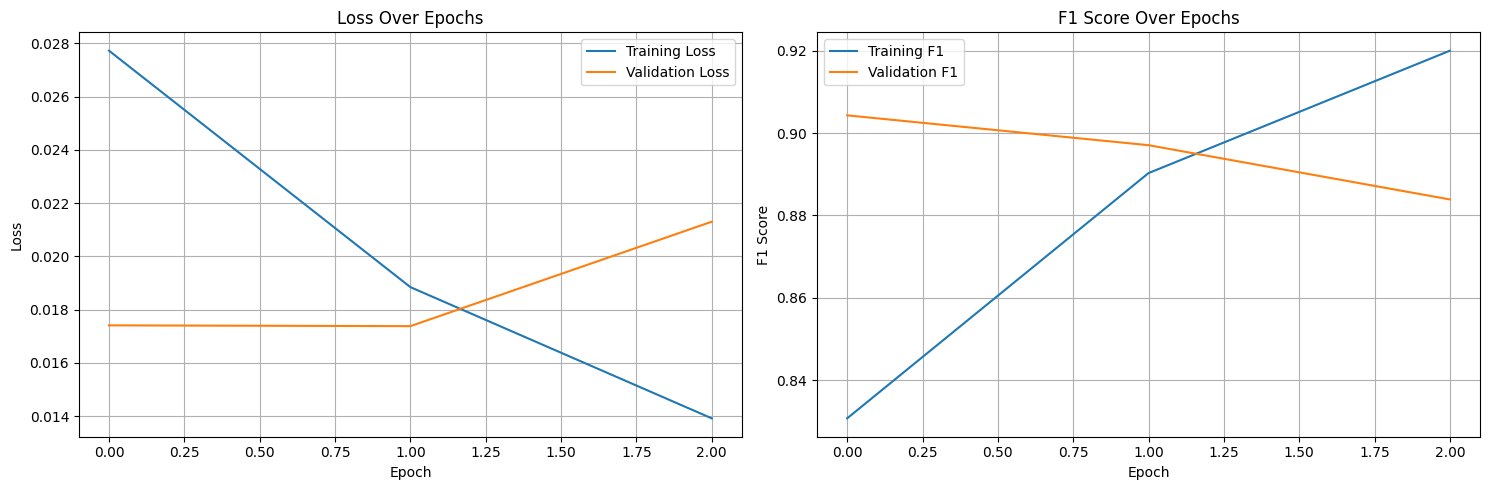

In [67]:
# 1. Plot Training History
import matplotlib.pyplot as plt


def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # F1 Score plot
    ax2.plot(history['train_f1'], label='Training F1')
    ax2.plot(history['val_f1'], label='Validation F1')
    ax2.set_title('F1 Score Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [70]:
def evaluate_and_visualize(model_path, test_loader, device):

    def evaluate_test_set(model, test_loader, device):
        model.eval()
        all_predictions = []
        all_labels = []
        test_loss = 0
        
        with torch.no_grad():
            for batch in tqdm(test_loader, desc='Testing'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].float().to(device)  # Convert to float for focal loss
                
                outputs = model(input_ids, attention_mask)
                
                # Calculate focal loss
                loss = sigmoid_focal_loss(
                    outputs.squeeze(),
                    labels,
                    alpha=0.75,
                    gamma=2.5,
                    reduction='mean'
                )
                test_loss += loss.item()
                
                # Get predictions using sigmoid
                predictions = (torch.sigmoid(outputs) > 0.5).squeeze().cpu().numpy()
                all_predictions.extend(predictions)
                all_labels.extend(labels.cpu().numpy())
        
        test_report = classification_report(all_labels, all_predictions)
        conf_matrix = confusion_matrix(all_labels, all_predictions)
        
        return test_loss/len(test_loader), test_report, conf_matrix
    
    model = CyberbullyingClassifier()
    model.load_state_dict(torch.load(model_path)['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    test_loss, test_report, conf_matrix = evaluate_test_set(model, test_loader, device)
    
    print("\nTest Set Results:")
    print("-" * 50)
    print("\nClassification Report:")
    print(test_report)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        'test_loss': test_loss,
        'test_report': test_report,
        'conf_matrix': conf_matrix
    }


/tmp/ipykernel_60608/296714033.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)['model_state_dict'])
Testing: 100%|█████████


Test Set Results:
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94     31789
         1.0       0.55      0.76      0.64      4131

    accuracy                           0.90     35920
   macro avg       0.76      0.84      0.79     35920
weighted avg       0.92      0.90      0.91     35920



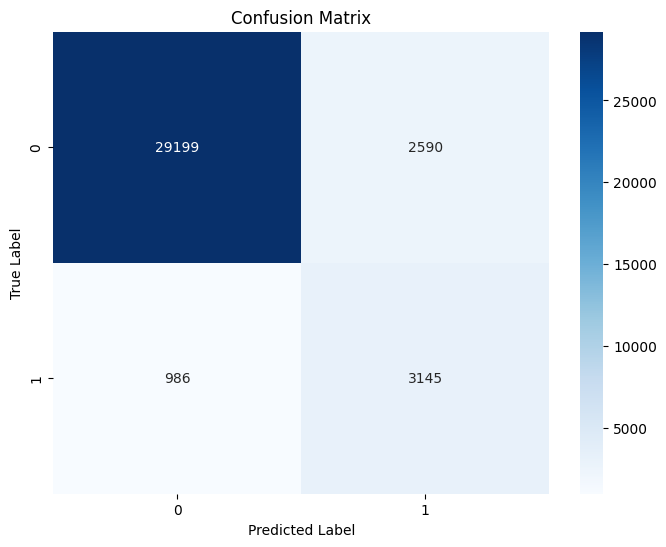

In [72]:
results = evaluate_and_visualize(
    model_path='/home/karthik_arun/ml/cyberbullying_checkpoints/full-data-no-aug/best_checkpoint.pt',
    test_loader=test_loader,
    device=device
)

## Augmenting the dataset with nlpaug 

In [21]:
def augment_toxic_samples(train_df):
    aug = nlpaw.ContextualWordEmbsAug(
        model_path='bert-base-uncased', 
        aug_min=1,
        aug_p=0.1,
        action="substitute",
        device = 'cuda'
    )
    
    toxic_samples = train_df[train_df['oh_label'] == 1]
    
    augmented_texts = []
    augmented_labels = []
    
    print("Augmenting toxic samples...")
    for _, row in tqdm(toxic_samples.iterrows()):
        for _ in range(2):
            aug_text = aug.augment(row['processed_text'], num_thread=4)[0]
            augmented_texts.append(aug_text)
            augmented_labels.append(1)
    
    aug_df = pd.DataFrame({
        'processed_text': augmented_texts,
        'oh_label': augmented_labels
    })
    
    combined_train_df = pd.concat([train_df, aug_df], ignore_index=True)
    combined_train_df = combined_train_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"Original training set size: {len(train_df)}")
    print(f"Augmented training set size: {len(combined_train_df)}")
    print("\nClass distribution in augmented training set:")
    print(combined_train_df['oh_label'].value_counts(normalize=True))
    
    return combined_train_df


In [22]:
augmented_train_df = augment_toxic_samples(train_df)

Augmenting toxic samples...


19291it [21:19, 15.07it/s]

Original training set size: 167721
Augmented training set size: 206303

Class distribution in augmented training set:
oh_label
0    0.719476
1    0.280524
Name: proportion, dtype: float64


In [25]:
augmented_train_df.head()

,processed_text,oh_label
0,november utc well guy going ask blocked intere...,0
1,talk,0
2,moved image piccolo daimao section list supern...,0
3,whoever wrote comment fuckin hero wooooo when,1
4,pet weasel,0


In [28]:
print("Dataset Statistics:")
print("-" * 50)
print("Original Training Set:")
print(train_df['oh_label'].value_counts())
print("\nAugmented Training Set:")
print(augmented_train_df['oh_label'].value_counts())

new_samples = len(augmented_train_df) - len(train_df)
print(f"\nNew samples generated: {new_samples}")


Dataset Statistics:
--------------------------------------------------
Original Training Set:
oh_label
0    148430
1     19291
Name: count, dtype: int64

Augmented Training Set:
oh_label
0    148430
1     57873
Name: count, dtype: int64

New samples generated: 38582


In [62]:
train_dataset = CyberbullyingDataset(augmented_train_df, tokenizer)

In [63]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

In [64]:
num_epochs = 4

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs
)

Starting training...

Epoch 1/4


Evaluating: 100%|██████████| 560/560 [01:21<00:00,  6.88it/s]



Train Loss: 0.0182 | Train F1: 0.8810
Val Loss: 0.0134 | Val F1: 0.9182

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     31704
           1       0.62      0.71      0.66      4120

    accuracy                           0.92     35824
   macro avg       0.79      0.83      0.81     35824
weighted avg       0.92      0.92      0.92     35824


Epoch 2/4


Evaluating: 100%|██████████| 560/560 [01:21<00:00,  6.85it/s]



Train Loss: 0.0120 | Train F1: 0.9256
Val Loss: 0.0141 | Val F1: 0.9162

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     31704
           1       0.60      0.73      0.66      4120

    accuracy                           0.91     35824
   macro avg       0.78      0.83      0.80     35824
weighted avg       0.92      0.91      0.92     35824

EarlyStopping counter: 1 out of 2

Epoch 3/4


Evaluating: 100%|██████████| 560/560 [01:20<00:00,  6.93it/s]


Train Loss: 0.0098 | Train F1: 0.9390
Val Loss: 0.0149 | Val F1: 0.9173

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     31704
           1       0.60      0.73      0.66      4120

    accuracy                           0.91     35824
   macro avg       0.78      0.83      0.81     35824
weighted avg       0.92      0.91      0.92     35824

EarlyStopping counter: 2 out of 2

Early stopping triggered after epoch 3


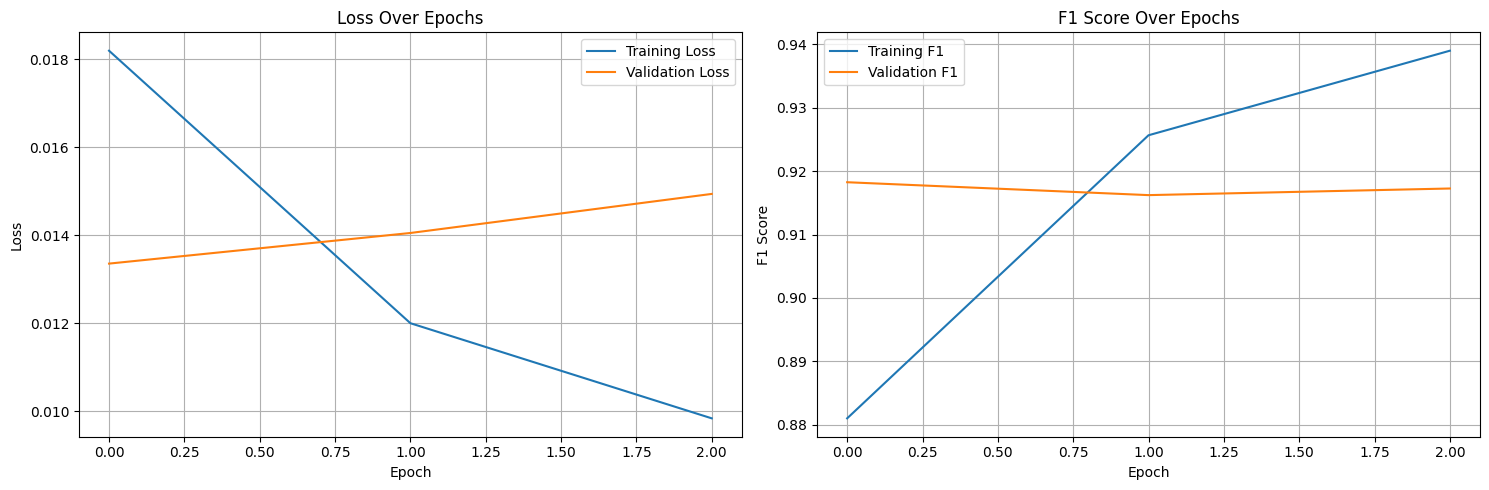

/tmp/ipykernel_26844/1423645951.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_model.pt')['model_state_dict'])
Testing: 100%


Test Set Results:
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     31789
           1       0.62      0.70      0.66      4131

    accuracy                           0.92     35920
   macro avg       0.79      0.82      0.80     35920
weighted avg       0.92      0.92      0.92     35920



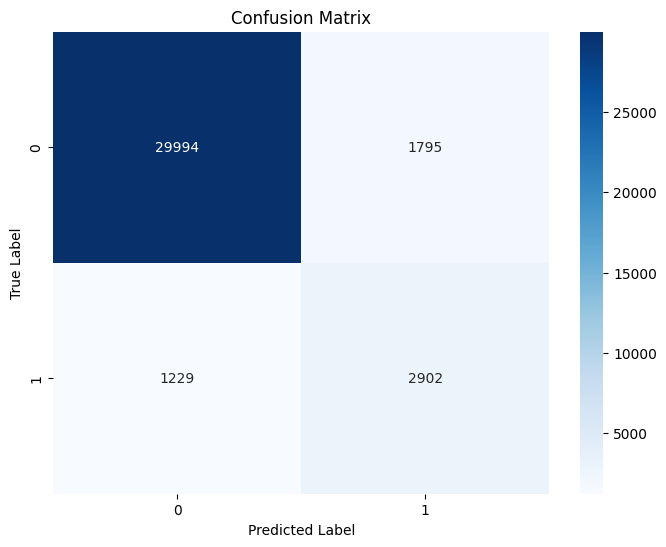

In [67]:
# Plot training history
plot_training_history(history)

# Load best model and evaluate on test set
best_model = CyberbullyingClassifier()
best_model.load_state_dict(torch.load('best_model.pt')['model_state_dict'])
best_model = best_model.to(device)

test_loss, test_report, conf_matrix = evaluate_test_set(best_model, test_loader, criterion, device)

# Print test results
print("\nTest Set Results:")
print("-" * 50)
print("\nClassification Report:")
print(test_report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save test results
with open('test_results.txt', 'w') as f:
    f.write("Test Set Results\n")
    f.write("-" * 50 + "\n")
    f.write("\nClassification Report:\n")
    f.write(test_report)


## Downsampling Non-Toxic Tweets

In [61]:
def downsample_majority_class(df):
    toxic = df[df['oh_label'] == 1]
    non_toxic = df[df['oh_label'] == 0]
    
    downsampled_non_toxic = resample(
        non_toxic,
        replace=False,
        n_samples=len(non_toxic)//2,
        random_state=42
    )
    
    downsampled_df = pd.concat([toxic, downsampled_non_toxic], ignore_index=True)
    return downsampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [62]:
downsampled_train_df = downsample_majority_class(train_df)
print("Original distribution:", train_df['oh_label'].value_counts())
print("Downsampled distribution:", downsampled_train_df['oh_label'].value_counts())

Original distribution: oh_label
0    148430
1     19291
Name: count, dtype: int64
Downsampled distribution: oh_label
0    74215
1    19291
Name: count, dtype: int64


In [63]:
train_dataset_downsampled = CyberbullyingDataset(downsampled_train_df, tokenizer)
train_loader_downsampled = DataLoader(
    train_dataset_downsampled,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

In [64]:
model = CyberbullyingClassifier().to(device)
optimizer = ADOPT(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=2, verbose=True
)

/home/karthik_arun/tf/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [65]:
experiment_id = "downsampled-data-no-aug"  
history, exp_id = train_model(
    model=model,
    train_loader=train_loader_downsampled,  
    val_loader=val_loader,                  
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    experiment_id=experiment_id,
    checkpoint_dir="cyberbullying_checkpoints",
    num_epochs=5
)


Starting experiment: downsampled-data-no-aug
Starting training...

Epoch 1/5


Evaluating: 100%|██████████| 560/560 [01:21<00:00,  6.90it/s]



Train Loss: 0.0277 | Train F1: 0.8307
Val Loss: 0.0174 | Val F1: 0.9043

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     31704
           1       0.54      0.77      0.63      4120

    accuracy                           0.90     35824
   macro avg       0.75      0.84      0.79     35824
weighted avg       0.92      0.90      0.90     35824

New best model saved with validation F1: 0.9043

Epoch 2/5


Evaluating: 100%|██████████| 560/560 [01:21<00:00,  6.91it/s]



Train Loss: 0.0188 | Train F1: 0.8903
Val Loss: 0.0174 | Val F1: 0.8971

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     31704
           1       0.50      0.82      0.62      4120

    accuracy                           0.89     35824
   macro avg       0.74      0.86      0.78     35824
weighted avg       0.92      0.89      0.90     35824

EarlyStopping counter: 1 out of 2

Epoch 3/5


Evaluating: 100%|██████████| 560/560 [01:22<00:00,  6.79it/s]



Train Loss: 0.0139 | Train F1: 0.9200
Val Loss: 0.0213 | Val F1: 0.8839

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     31704
           1       0.46      0.85      0.60      4120

    accuracy                           0.87     35824
   macro avg       0.72      0.86      0.76     35824
weighted avg       0.92      0.87      0.88     35824

EarlyStopping counter: 2 out of 2

Early stopping triggered after epoch 3


/tmp/ipykernel_60608/296714033.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)['model_state_dict'])
Testing: 100%|█████████


Test Set Results:
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94     31789
         1.0       0.55      0.77      0.64      4131

    accuracy                           0.90     35920
   macro avg       0.76      0.85      0.79     35920
weighted avg       0.92      0.90      0.91     35920



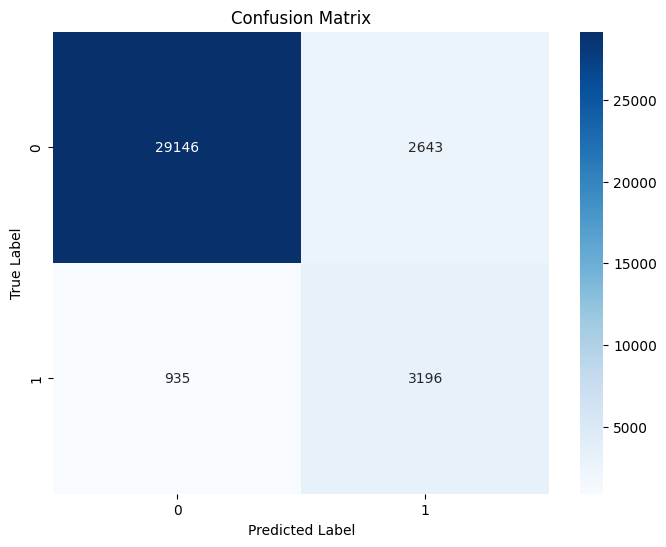

In [73]:
results_downsampled_experiment = evaluate_and_visualize(
    model_path='/home/karthik_arun/ml/cyberbullying_checkpoints/downsampled-data-no-aug/best_checkpoint.pt',
    test_loader=test_loader,
    device=device
)

## Model exporting to ONNX and inference checks

In [84]:
def export_to_onnx(model, tokenizer, output_path="cyberbullying_model.onnx"):

    model.eval()
    dummy_input = tokenizer(
        "This is a sample text",
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    
    input_ids = dummy_input['input_ids'].to(model.bert.device)
    attention_mask = dummy_input['attention_mask'].to(model.bert.device)
    
    torch.onnx.export(
        model,                                   
        (input_ids, attention_mask),             
        output_path,                            
        export_params=True,                      
        opset_version=14,                        
        do_constant_folding=True,                
        input_names=['input_ids',                
                    'attention_mask'],
        output_names=['output'],                 
        dynamic_axes={                           
            'input_ids': {0: 'batch_size'},
            'attention_mask': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    print(f"Model exported to {output_path}")


In [85]:
export_to_onnx(model, tokenizer)

Model exported to cyberbullying_model.onnx


In [126]:
def verify_onnx_model(onnx_path):
    model = onnx.load(onnx_path)
    onnx.checker.check_model(model)
    print("ONNX model verified successfully!")
    
    for input in model.graph.input:
        print(f"Input: {input.name}, Shape: {[d.dim_value for d in input.type.tensor_type.shape.dim]}")
    for output in model.graph.output:
        print(f"Output: {output.name}, Shape: {[d.dim_value for d in output.type.tensor_type.shape.dim]}")


In [127]:
verify_onnx_model("cyberbullying_model.onnx")

ONNX model verified successfully!
Input: input_ids, Shape: [0, 128]
Input: attention_mask, Shape: [0, 128]
Output: output, Shape: [0, 1]


In [128]:
def initialize_inference(onnx_path):
    session = ort.InferenceSession(
        onnx_path,
        providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
    )
    return session

In [129]:
session = initialize_inference("cyberbullying_model.onnx")

/home/karthik_arun/tf/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [130]:
def predict_text(text, session, tokenizer):
    inputs = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    
    ort_inputs = {
        'input_ids': inputs['input_ids'].numpy(),
        'attention_mask': inputs['attention_mask'].numpy()
    }
    
    ort_outputs = session.run(None, ort_inputs)
    probabilities = 1 / (1 + np.exp(-ort_outputs[0]))
    predictions = (probabilities > 0.5).astype(int)
    
    return predictions, probabilities


In [131]:
test_texts = [
    "You are awesome!",
    "stfu clown",
    "Have a great day"
]

In [132]:
for text in test_texts:
    pred, prob = predict_text(text, session, tokenizer)
    print(f"\nText: {text}")
    print(f"Prediction: {'Toxic' if pred[0] == 1 else 'Non-toxic'}")
    print(f"Confidence: {prob[0][0]:.4f}")


Text: You are awesome!
Prediction: Non-toxic
Confidence: 0.1578

Text: stfu clown
Prediction: Toxic
Confidence: 0.6804

Text: Have a great day
Prediction: Non-toxic
Confidence: 0.1270
